In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, PowerTransformer

from src.auxiliares import dataframe_coeficientes
from src.config import DADOS_LIMPOS, MODELO_LINEAR_REGRESSION
from src.graficos import plot_coeficientes, plot_comparar_metricas_modelos
from src.models import RANDOM_STATE
from src.models import (
    grid_search_cv_classificador,
    treinar_e_validar_modelo_classificacao,
    organiza_resultados,
)

#pandas configurando para mostrar todas as linhas e colunas
pd.set_option ('display.max_columns', None)

#configurando pandas para não mostrar notação científica
pd.set_option('display.float_format', lambda x: '%.2f' % x)


sns.set_theme(palette='viridis_r')

In [2]:
# Carregamento e preparação dos dados
df = pd.read_parquet(DADOS_LIMPOS)

df.head()

,area_mean,area_se,area_worst,compactness_mean,compactness_se,compactness_worst,concave points_mean,concave points_se,concave points_worst,concavity_mean,concavity_se,concavity_worst,diagnosis,fractal_dimension_mean,fractal_dimension_se,fractal_dimension_worst,perimeter_mean,perimeter_se,perimeter_worst,radius_mean,radius_se,radius_worst,smoothness_mean,smoothness_se,smoothness_worst,symmetry_mean,symmetry_se,symmetry_worst,texture_mean,texture_se,texture_worst
0,1001.00,153.40,2019.00,0.28,0.05,0.67,0.15,0.02,0.27,0.30,0.05,0.71,M,0.08,0.01,0.12,122.80,8.59,184.60,17.99,1.09,25.38,0.12,0.01,0.16,0.24,0.03,0.46,10.38,0.91,17.33
1,1326.00,74.08,1956.00,0.08,0.01,0.19,0.07,0.01,0.19,0.09,0.02,0.24,M,0.06,0.00,0.09,132.90,3.40,158.80,20.57,0.54,24.99,0.08,0.01,0.12,0.18,0.01,0.28,17.77,0.73,23.41
2,1203.00,94.03,1709.00,0.16,0.04,0.42,0.13,0.02,0.24,0.20,0.04,0.45,M,0.06,0.00,0.09,130.00,4.58,152.50,19.69,0.75,23.57,0.11,0.01,0.14,0.21,0.02,0.36,21.25,0.79,25.53
3,386.10,27.23,567.70,0.28,0.07,0.87,0.11,0.02,0.26,0.24,0.06,0.69,M,0.10,0.01,0.17,77.58,3.44,98.87,11.42,0.50,14.91,0.14,0.01,0.21,0.26,0.06,0.66,20.38,1.16,26.50
4,1297.00,94.44,1575.00,0.13,0.02,0.20,0.10,0.02,0.16,0.20,0.06,0.40,M,0.06,0.01,0.08,135.10,5.44,152.20,20.29,0.76,22.54,0.10,0.01,0.14,0.18,0.02,0.24,14.34,0.78,16.67


In [3]:
X= df.drop(columns=['diagnosis'])
y= df['diagnosis']

In [4]:
# Codificação da variável target (B=0, M=1)
le =LabelEncoder()

y=le.fit_transform(y)


In [5]:
# Estratificação para validação cruzada
kf= StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [6]:
# Pipeline de pré-processamento (PowerTransformer para dados assimétricos)
preprocessamento = Pipeline(
    steps=[("scaler", PowerTransformer())]
)

In [7]:
#comparação de três abordagens
classificadores = {
    'DummyClassifier':{
        'preprocessor': None,
        'classificador': DummyClassifier(strategy='stratified')
    },

      'LogisticRegression':{
        'preprocessor': preprocessamento,
        'classificador': LogisticRegression()
    },

    'SGDClassifier':{
        'preprocessor': preprocessamento,
        'classificador': SGDClassifier()
    },

}

In [8]:
resultados = {
    nome_modelo: treinar_e_validar_modelo_classificacao(X, y, kf, **classificador)
    for nome_modelo, classificador in classificadores.items()
}
df_resultados = organiza_resultados(resultados)
df_resultados

,model,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,test_f2_score,time_seconds
0,DummyClassifier,0.00,0.02,0.58,0.55,0.43,0.44,0.42,0.51,0.38,0.42,0.02
1,DummyClassifier,0.00,0.02,0.52,0.47,0.29,0.32,0.26,0.48,0.37,0.27,0.02
2,DummyClassifier,0.00,0.01,0.59,0.54,0.41,0.43,0.38,0.58,0.42,0.39,0.01
3,DummyClassifier,0.00,0.01,0.51,0.49,0.39,0.36,0.43,0.53,0.38,0.41,0.01
4,DummyClassifier,0.00,0.01,0.49,0.47,0.36,0.33,0.38,0.55,0.40,0.37,0.01
5,LogisticRegression,0.10,0.02,0.97,0.97,0.97,0.95,0.98,1.00,1.00,0.97,0.12
6,LogisticRegression,0.08,0.03,0.96,0.95,0.95,1.00,0.91,1.00,1.00,0.92,0.11
7,LogisticRegression,0.12,0.02,0.96,0.96,0.95,0.97,0.93,0.99,0.98,0.94,0.15
8,LogisticRegression,0.09,0.02,0.99,0.99,0.99,0.98,1.00,1.00,1.00,1.00,0.12
9,LogisticRegression,0.09,0.02,0.98,0.98,0.98,1.00,0.95,1.00,1.00,0.96,0.11


In [9]:
df_resultados.groupby('model').mean().sort_values('test_f2_score')

,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,test_f2_score,time_seconds
model,,,,,,,,,,,
DummyClassifier,0.00,0.01,0.54,0.50,0.37,0.38,0.37,0.53,0.39,0.37,0.01
SGDClassifier,0.08,0.02,0.96,0.96,0.95,0.95,0.94,0.99,0.99,0.95,0.10
LogisticRegression,0.10,0.02,0.98,0.97,0.97,0.98,0.95,1.00,1.00,0.96,0.12


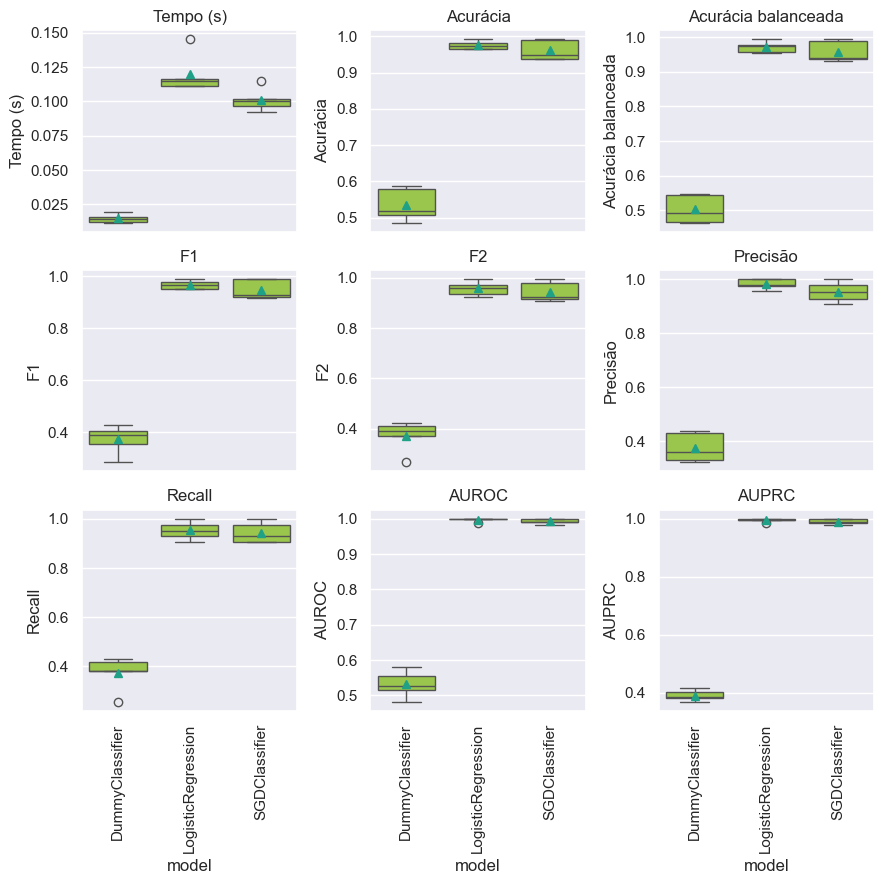

In [10]:
plot_comparar_metricas_modelos(df_resultados)

In [11]:
param_grid= {
    "clf__C":[0.1, 1, 10, 100],
    "clf__penalty": ['l2', 'l1'],
    'clf__class_weight':[None, 'balanced'],
    'clf__solver': ['liblinear','saga'],
}

In [12]:
clf = LogisticRegression(random_state=RANDOM_STATE)
grid_search = grid_search_cv_classificador(
    clf, param_grid, kf, preprocessamento, refit_metric="f2_score"
)
grid_search

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        Pipeline(steps=[('scaler',
                                                         PowerTransformer())])),
                                       ('clf',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 10, 100],
                         'clf__class_weight': [None, 'balanced'],
                         'clf__penalty': ['l2', 'l1'],
                         'clf__solver': ['liblinear', 'saga']},
             refit='f2_score',
             scoring={'accuracy': 'accuracy',
                      'average_precision': 'average_precision',
                      'balanced_accuracy': 'balanced_accuracy', 'f1': 'f1',
                      'f2_score': make_scorer(fbeta_score, response_method='predict', beta=2, average=binary),
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'},
             verbose=1)

In [13]:
grid_search.fit(X,y)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        Pipeline(steps=[('scaler',
                                                         PowerTransformer())])),
                                       ('clf',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 10, 100],
                         'clf__class_weight': [None, 'balanced'],
                         'clf__penalty': ['l2', 'l1'],
                         'clf__solver': ['liblinear', 'saga']},
             refit='f2_score',
             scoring={'accuracy': 'accuracy',
                      'average_precision': 'average_precision',
                      'balanced_accuracy': 'balanced_accuracy', 'f1': 'f1',
                      'f2_score': make_scorer(fbeta_score, response_method='predict', beta=2, average=binary),
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'},
             verbose=1)

In [14]:
grid_search.best_params_

{'clf__C': 0.1,
 'clf__class_weight': 'balanced',
 'clf__penalty': 'l2',
 'clf__solver': 'liblinear'}

In [15]:
grid_search.best_score_

0.9681259699741114

In [16]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', PowerTransformer())])),
                ('clf',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    random_state=42, solver='liblinear'))])

In [17]:
#estudo de coeficientes
grid_search.best_estimator_['preprocessor'].get_feature_names_out()

array(['area_mean', 'area_se', 'area_worst', 'compactness_mean',
       'compactness_se', 'compactness_worst', 'concave points_mean',
       'concave points_se', 'concave points_worst', 'concavity_mean',
       'concavity_se', 'concavity_worst', 'fractal_dimension_mean',
       'fractal_dimension_se', 'fractal_dimension_worst',
       'perimeter_mean', 'perimeter_se', 'perimeter_worst', 'radius_mean',
       'radius_se', 'radius_worst', 'smoothness_mean', 'smoothness_se',
       'smoothness_worst', 'symmetry_mean', 'symmetry_se',
       'symmetry_worst', 'texture_mean', 'texture_se', 'texture_worst'],
      dtype=object)

In [18]:
#estudo de coeficientes
grid_search.best_estimator_['clf'].coef_

array([[ 0.30030373,  0.49901067,  0.44196486, -0.11592452, -0.34179336,
         0.04522922,  0.47616633,  0.05119228,  0.43086941,  0.43664788,
         0.01779255,  0.42184701, -0.15567598, -0.2089878 ,  0.1507692 ,
         0.2686392 ,  0.31634989,  0.37403906,  0.2724541 ,  0.47042011,
         0.41240706,  0.17752245,  0.00417972,  0.44474679,  0.15473796,
        -0.29835742,  0.38232923,  0.48092219, -0.04421988,  0.56955113]])

In [19]:
# Coeficientes originais
coefs = dataframe_coeficientes(
    grid_search.best_estimator_['clf'].coef_[0],
    grid_search.best_estimator_['preprocessor'].get_feature_names_out() #o nome das features
)
coefs    

,coeficiente
compactness_se,-0.34
symmetry_se,-0.30
fractal_dimension_se,-0.21
fractal_dimension_mean,-0.16
compactness_mean,-0.12
texture_se,-0.04
smoothness_se,0.00
concavity_se,0.02
compactness_worst,0.05
concave points_se,0.05


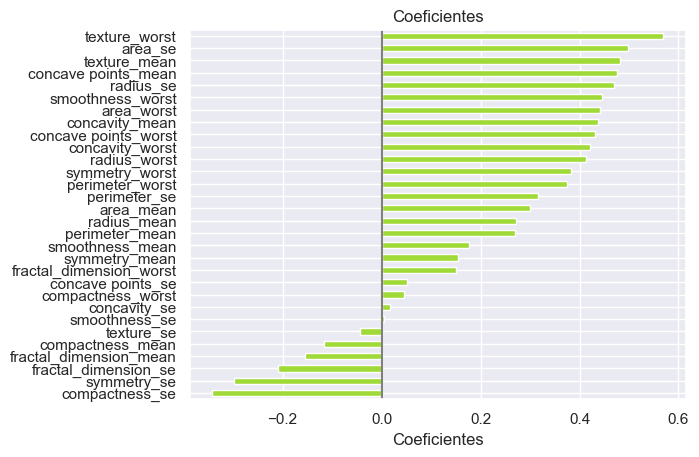

In [20]:
plot_coeficientes(coefs)

In [21]:
# Coeficientes transformados em odds ratio
coefs_odds = coefs.copy()
coefs_odds['coeficiente'] = np.exp(coefs['coeficiente'])

coefs_odds

,coeficiente
compactness_se,0.71
symmetry_se,0.74
fractal_dimension_se,0.81
fractal_dimension_mean,0.86
compactness_mean,0.89
texture_se,0.96
smoothness_se,1.00
concavity_se,1.02
compactness_worst,1.05
concave points_se,1.05


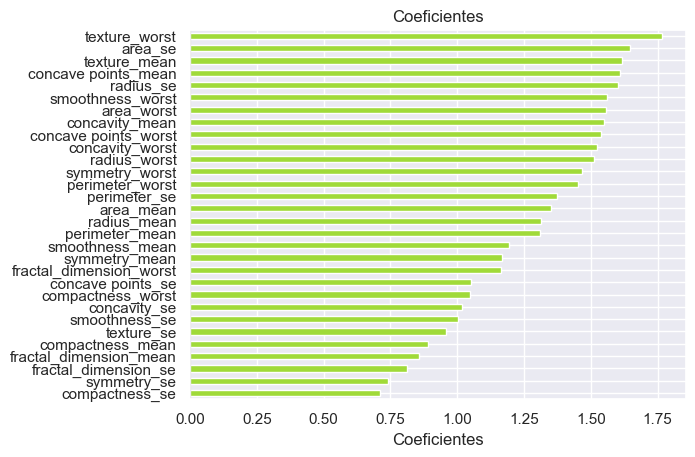

In [22]:
plot_coeficientes(coefs_odds)  

In [23]:
#Avaliação de como o preprocessamento afetou as features e como está relacionado com os coeficientes
X_scaled = grid_search.best_estimator_['preprocessor'].transform(X)

X_scaled = pd.DataFrame(X_scaled, columns=grid_search.best_estimator_['preprocessor'].get_feature_names_out())
X_scaled.head()

,area_mean,area_se,area_worst,compactness_mean,compactness_se,compactness_worst,concave points_mean,concave points_se,concave points_worst,concavity_mean,concavity_se,concavity_worst,fractal_dimension_mean,fractal_dimension_se,fractal_dimension_worst,perimeter_mean,perimeter_se,perimeter_worst,radius_mean,radius_se,radius_worst,smoothness_mean,smoothness_se,smoothness_worst,symmetry_mean,symmetry_se,symmetry_worst,texture_mean,texture_se,texture_worst
0,1.13,1.88,1.65,2.17,1.45,1.94,1.85,0.81,1.94,1.86,1.16,1.73,1.89,1.35,1.72,1.26,1.97,1.81,1.13,1.89,1.62,1.50,-0.03,1.28,1.95,1.36,2.20,-2.68,-0.50,-1.49
1,1.63,1.28,1.61,-0.38,-0.79,-0.30,0.82,0.43,1.10,0.29,-0.46,0.07,-0.96,0.19,0.54,1.53,0.73,1.43,1.62,0.96,1.58,-0.82,-0.63,-0.33,0.10,-1.03,-0.12,-0.26,-1.00,-0.29
2,1.46,1.50,1.43,1.16,1.12,1.21,1.68,1.42,1.72,1.40,0.60,1.01,-0.29,0.74,0.45,1.45,1.21,1.32,1.46,1.46,1.42,0.96,-0.15,0.58,0.99,0.57,1.22,0.55,-0.83,0.07
3,-0.84,0.05,-0.44,2.20,1.96,2.28,1.42,1.19,1.86,1.64,1.24,1.68,2.71,1.94,2.52,-0.51,0.76,-0.04,-0.76,0.79,-0.08,2.78,0.98,2.86,2.36,2.35,3.25,0.36,0.10,0.23
4,1.60,1.50,1.31,0.76,0.25,-0.13,1.41,1.21,0.81,1.41,1.25,0.82,-0.51,0.98,-0.28,1.58,1.45,1.32,1.57,1.48,1.29,0.34,1.55,0.28,0.09,-0.23,-0.94,-1.23,-0.85,-1.64


In [24]:
df_scaled = pd.concat([X_scaled, pd.Series(y, name='diagnosis')], axis=1)
df_scaled.head()

,area_mean,area_se,area_worst,compactness_mean,compactness_se,compactness_worst,concave points_mean,concave points_se,concave points_worst,concavity_mean,concavity_se,concavity_worst,fractal_dimension_mean,fractal_dimension_se,fractal_dimension_worst,perimeter_mean,perimeter_se,perimeter_worst,radius_mean,radius_se,radius_worst,smoothness_mean,smoothness_se,smoothness_worst,symmetry_mean,symmetry_se,symmetry_worst,texture_mean,texture_se,texture_worst,diagnosis
0,1.13,1.88,1.65,2.17,1.45,1.94,1.85,0.81,1.94,1.86,1.16,1.73,1.89,1.35,1.72,1.26,1.97,1.81,1.13,1.89,1.62,1.50,-0.03,1.28,1.95,1.36,2.20,-2.68,-0.50,-1.49,1
1,1.63,1.28,1.61,-0.38,-0.79,-0.30,0.82,0.43,1.10,0.29,-0.46,0.07,-0.96,0.19,0.54,1.53,0.73,1.43,1.62,0.96,1.58,-0.82,-0.63,-0.33,0.10,-1.03,-0.12,-0.26,-1.00,-0.29,1
2,1.46,1.50,1.43,1.16,1.12,1.21,1.68,1.42,1.72,1.40,0.60,1.01,-0.29,0.74,0.45,1.45,1.21,1.32,1.46,1.46,1.42,0.96,-0.15,0.58,0.99,0.57,1.22,0.55,-0.83,0.07,1
3,-0.84,0.05,-0.44,2.20,1.96,2.28,1.42,1.19,1.86,1.64,1.24,1.68,2.71,1.94,2.52,-0.51,0.76,-0.04,-0.76,0.79,-0.08,2.78,0.98,2.86,2.36,2.35,3.25,0.36,0.10,0.23,1
4,1.60,1.50,1.31,0.76,0.25,-0.13,1.41,1.21,0.81,1.41,1.25,0.82,-0.51,0.98,-0.28,1.58,1.45,1.32,1.57,1.48,1.29,0.34,1.55,0.28,0.09,-0.23,-0.94,-1.23,-0.85,-1.64,1


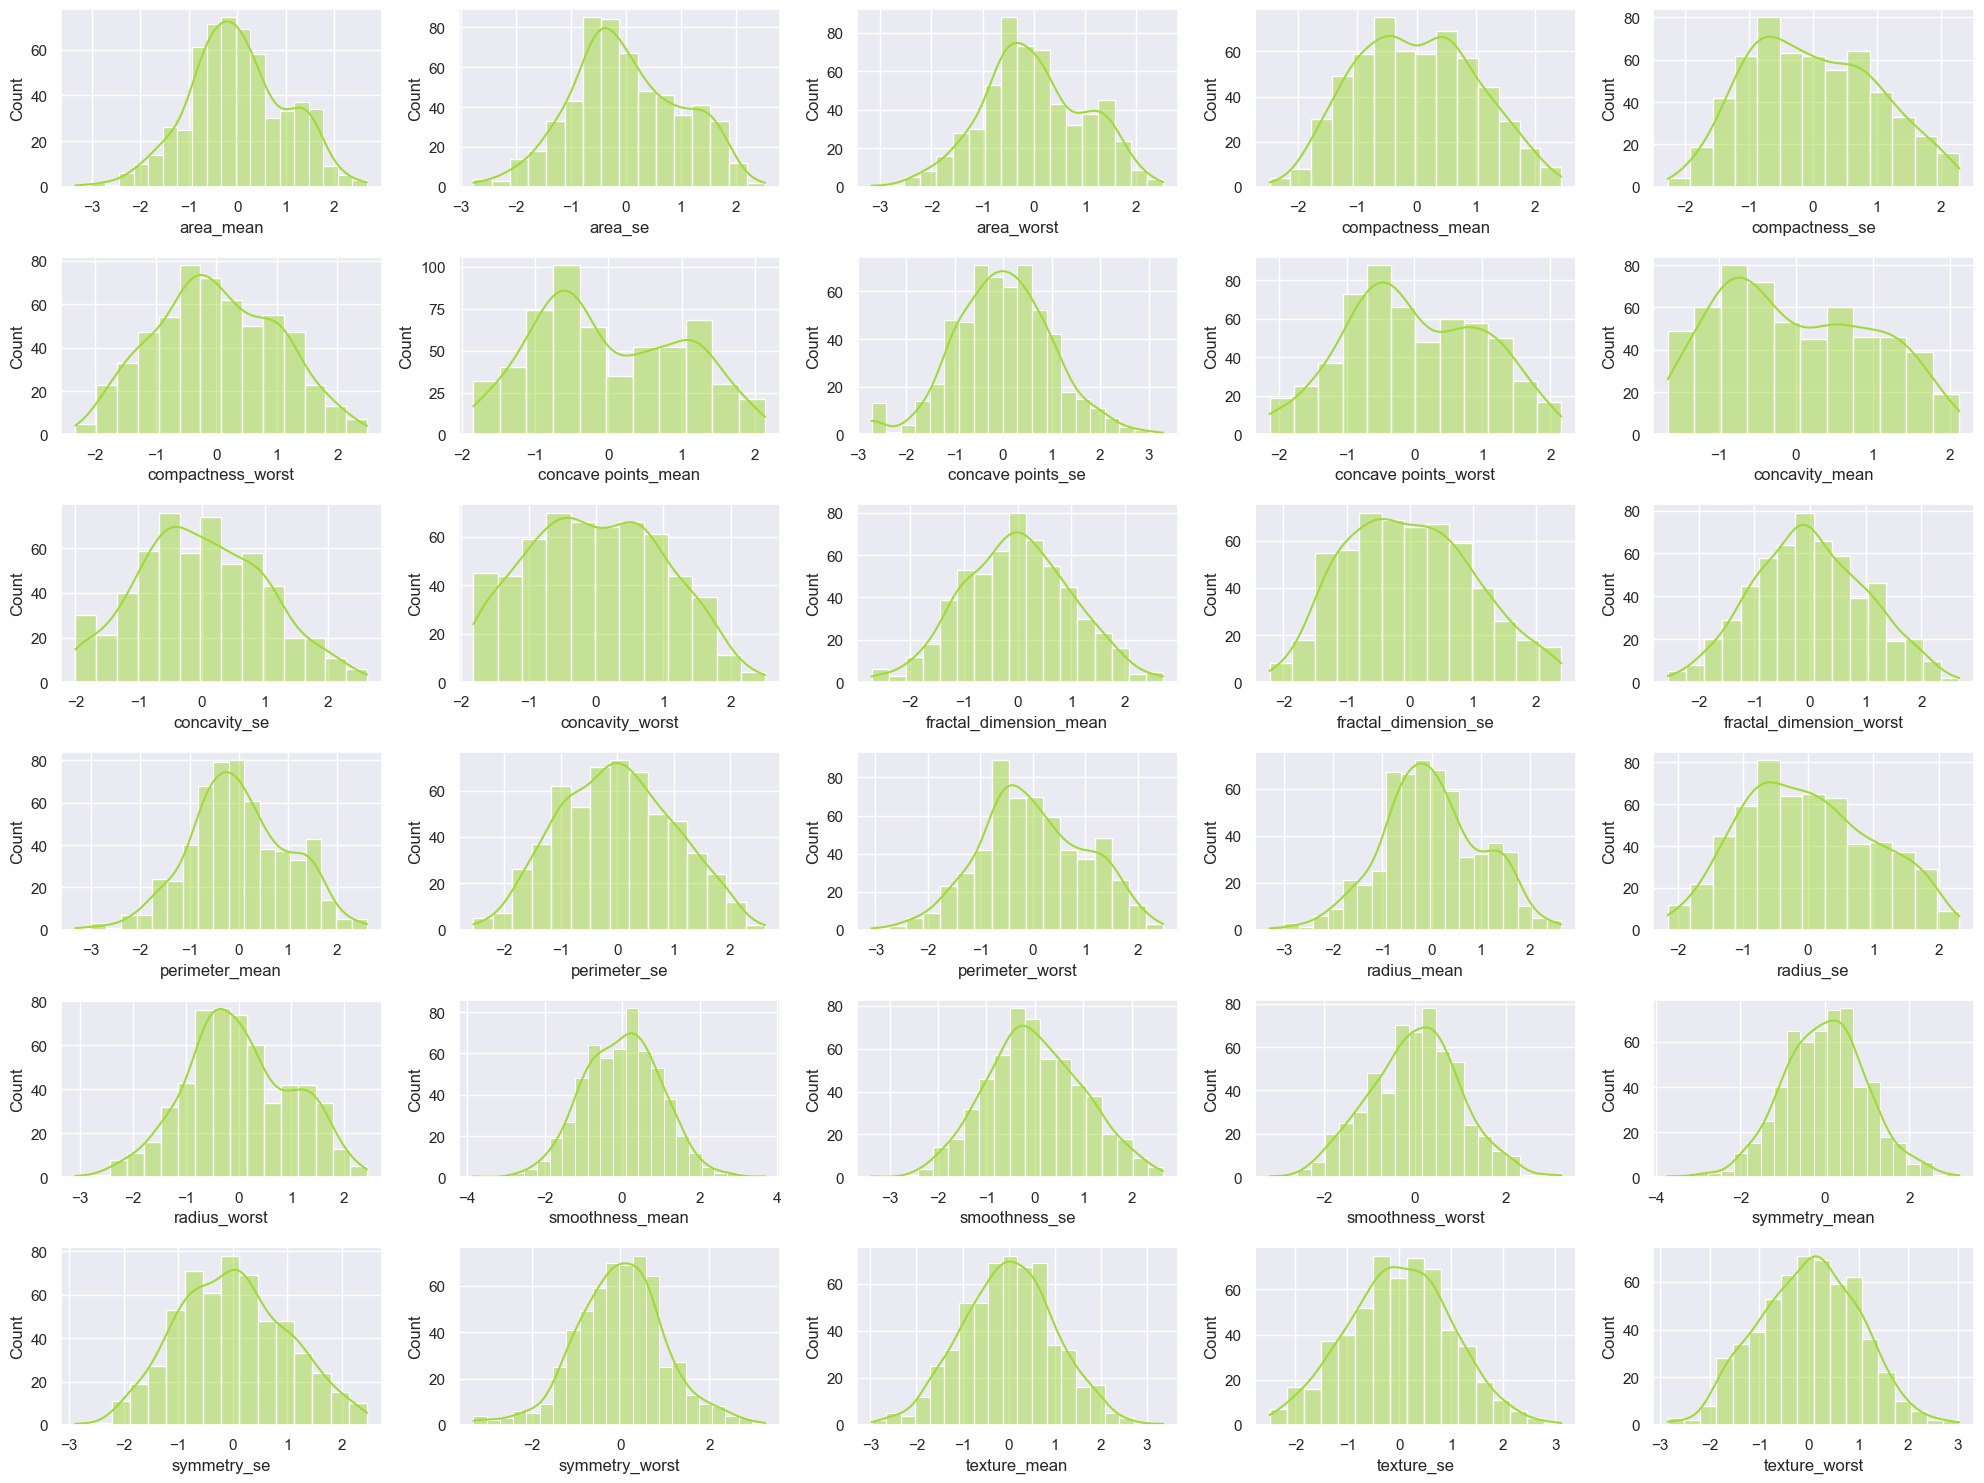

In [25]:
fig, axs = plt.subplots(6,5, figsize = (20,15))
for ax, coluna in zip(axs.flatten(), df_scaled.select_dtypes('number').columns):
    sns.histplot(x=coluna, ax=ax, data=df_scaled, kde=True)
    
plt.tight_layout()
plt.show()

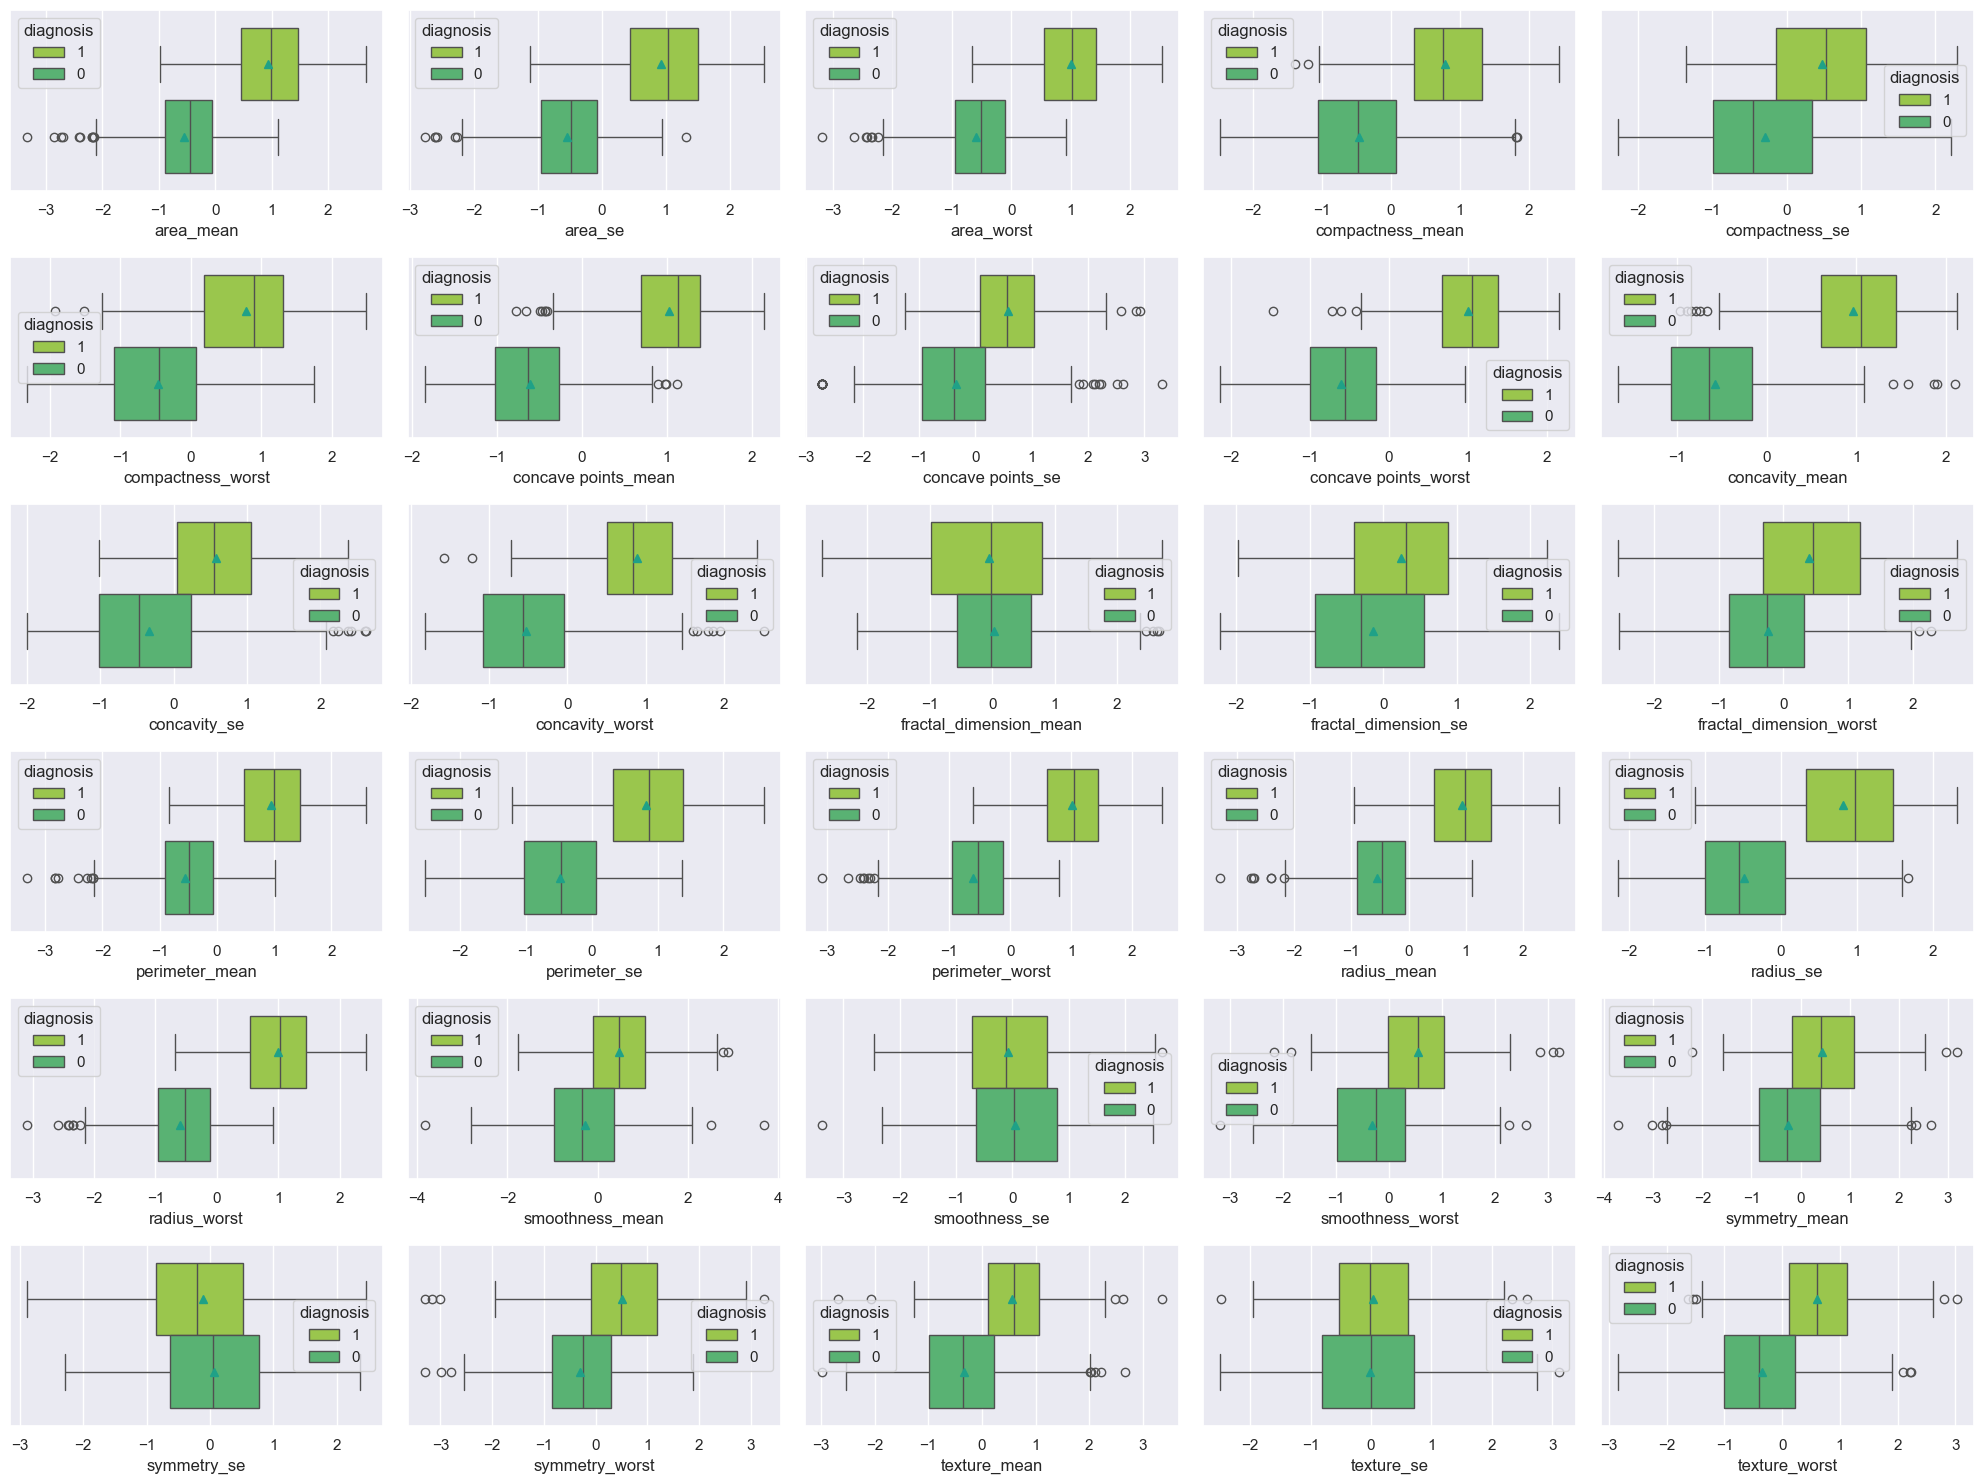

In [26]:
fig, axs = plt.subplots(6,5, figsize = (20,15))
for ax, coluna in zip(axs.flatten(), df_scaled.columns):
    sns.boxplot(x=coluna, ax=ax, data=df_scaled, showmeans=True, hue='diagnosis', hue_order=[1, 0])#inverter a ordem do hue, para compararmos com o gráfico eda
    
plt.tight_layout()
plt.show()

In [29]:
joblib.dump(grid_search, MODELO_LINEAR_REGRESSION)

['D:\\ciencias_dados\\python_pratica\\hashtag\\ciencias_dados\\machine_learning\\comparativo_diversos_modelos_classificação\\modelos\\lr.pkl']

### Conclusão

Modelos lineares como Regressão Logística assumem resíduos normalmente distribuídos. A análise exploratória mostrou assimetria nos dados e outliers, o que nos levou a escolher o PowerTransformer para melhorar o desempenho do modelo.

Os modelos SGDClassifier e Logistic Regression foram comparados usando validação cruzada estratificada. O F2-score foi selecionado como métrica principal por dar mais peso ao recall (importante para casos de diagnóstico médico).

A análise de importância das features - comparando coeficientes originais com odds ratios - validou as colunas mais relevantes identificadas na análise exploratória inicial. Essa confirmação é especialmente relevante porque a EDA original foi feita antes de qualquer pré-processamento.

Podemos observar que:

Todas as features estão na mesma escala

A assimetria observada na EDA foi significativamente reduzida

As distribuições transformadas estão muito mais próximas da curva normal

### Conclusion

Linear models like Logistic Regression assume normally distributed residuals. The exploratory data analysis revealed skewed data distributions and outliers, which led to choose the PowerTransformer to improve model performance.

It was compared SGDClassifier and Logistic Regression models using stratified cross-validation. The F2-score was selected as our primary metric as it gives more weight to recall (important for medical diagnosis use cases).

The feature importance analysis - comparing raw coefficients with odds ratio transformed coefficients - validated the key features identified during our initial exploratory analysis. This confirmation is particularly meaningful because the original EDA was performed before any data preprocessing.

We can observe that:

All features are now on the same scale

The data skewness observed during EDA was significantly reduced

The transformed distributions are much closer to normal curves